# Project demonstration

This notebook serves as a demonstration of what the toolbox can do. This project is a work in progress, so there will be updates to the code and subsequently the applications. Below are some highlights of what is currently possible.

## Datasets

The starting point of the project is the ability to easily load chemical datasets into a format that is usable from a Machine Learning perspective. All the relevant datasets make use of **SMILES** (Simplified molecular-input line-entry system) to store information on molecules. The in-built DataSets then take the SMILES representation of molecules together with a target array and any other additional information, and load then into **graphs**.

Below is an example of an implemented dataset that can, similarly to the torch datasets, download and load a dataset from the internet.

### Jean-Claude Bradley Open Melting Point Dataset

In [1]:
from grape.datasets import BradleyDoublePlus
print(f'length of dataset at the start: {3024}')
data = BradleyDoublePlus(log=True, only_organic=True)
print(f'length of dataset at the end: {len(data)}')

length of dataset at the start: 3024
SMILES [O-][N+]#N in index 1 does not contain at least one carbon and will be ignored.
SMILES FS(F)(=O)=O in index 2 does not contain at least one carbon and will be ignored.
SMILES BrBr in index 4 does not contain at least one carbon and will be ignored.
SMILES II in index 8 does not contain at least one carbon and will be ignored.
SMILES ClS(Cl)(=O)=O in index 79 does not contain at least one carbon and will be ignored.
SMILES B(OCC)(OCC)OCC in index 144 contains the atom B that is not permitted and will be ignored.
SMILES c1cccn1 in index 308 is not valid.
SMILES N#Cc3cncc3c1cccc2OC(F)(F)Oc12 in index 370 is not valid.
SMILES CC[Si](CC)(CC)CC in index 519 contains the atom Si that is not permitted and will be ignored.
SMILES CC[Si](CC)(Cl)Cl in index 541 contains the atom Si that is not permitted and will be ignored.
SMILES [SiH](Cl)(Cl)Cl in index 565 contains the atom Si that is not permitted and will be ignored.
SMILES [SiH](Cl)(Cl)Cl in index

As seen above, the data loader filters the SMILES based a few different criteria. One of them is a check if rdkit recognizes the SMILES representation as valid, another one is the use of a list of *allowed* atom symbols. After filtering, we can access the information using the regular class notations.

### Example outputs

In [2]:
# SMILES
data.smiles[0:5]

array(['CC1CCC1', 'CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C',
       'CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21', 'CN(C)C',
       'ClC(Cl)(Cl)Cl'], dtype=object)

In [3]:
# Their corresponding graphs, saved using the torch geometric Data objects.
data[0:5]

[Data(x=[5, 43], edge_index=[2, 10], edge_attr=[10, 12], y=[1]),
 Data(x=[25, 43], edge_index=[2, 52], edge_attr=[52, 12], y=[1]),
 Data(x=[25, 43], edge_index=[2, 54], edge_attr=[54, 12], y=[1]),
 Data(x=[4, 43], edge_index=[2, 6], edge_attr=[6, 12], y=[1]),
 Data(x=[5, 43], edge_index=[2, 8], edge_attr=[8, 12], y=[1])]

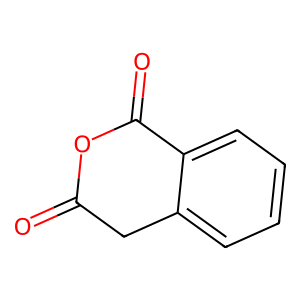

In [4]:
data.draw_smile(1000)

In [5]:
# We can also save and load the dataset as such:
# Dataset are saved using pickle, which allows for fast saving and loading. Saving a dataset and then loading instead of loading from, for example, an excel file is about 10 to 20 times faster.

from grape.utils import DataSet

data.save_dataset('BradleyDoublePlus')
loaded_dataset = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/BradleyDoublePlus.pickle')
loaded_dataset.smiles[0:5]

File saved at: ./data/processed/BradleyDoublePlus.pickle
Loaded dataset.


array(['CC1CCC1', 'N#[N+][O-]', 'O=S(=O)(F)F',
       'CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C', 'BrBr'], dtype=object)

### Analysis

There are several options to analyze a loaded dataset. Below are some of these options.

#### Compound numbers chart
This chart is generated using a simple clustering algorithm that checks the letter in the SMILES and puts them into the below seen molecule classes. For example, if a SMILES only contains an 'O' and no other class letter, then it is part of 'Oxygenated'. If it contains 'O' and 'Cl', then it is part of 'Multifunctional'.

<Axes: xlabel='compound class', ylabel='number of molecules'>

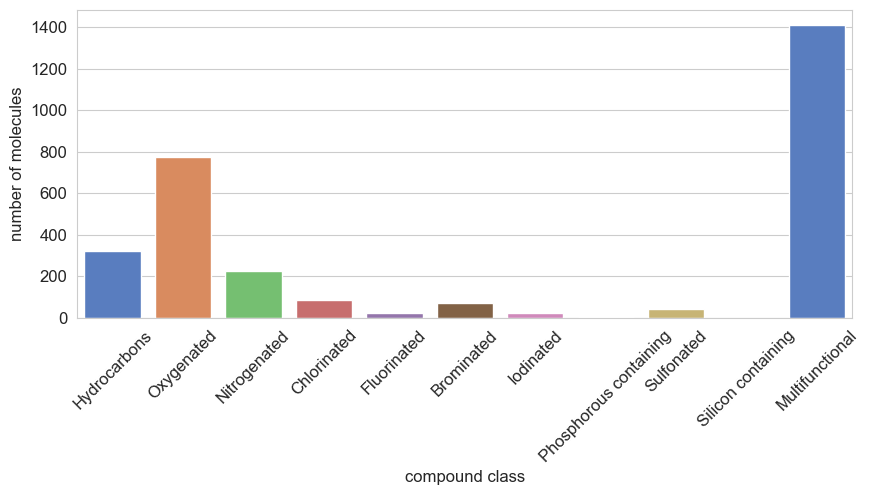

In [6]:
from grape.plots import compound_nums_chart

compound_nums_chart(data.smiles, fig_size=(10,4))

#### Classyfire
An almost always more useful clustering is using the Classyfire [1] classification done by Feunang et al.. In code terms, we pull the online documentation of the molecules in question with their Classyfire information, read it and cluster them based on that. This approach is far superior over the simple one above, but can take very long to do (it takes about 2 min to retrieve the information for 100 molecules).

In [7]:
subset_smiles = data.smiles[100:200]

from grape.analysis import classyfire, classyfire_result_analysis
ids, data_ids = classyfire(subset_smiles, log=False)
smile_classes, class_num_dictionary = classyfire_result_analysis(idx=ids)
print(class_num_dictionary)

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

Some InChikeys were not available. Please check "Missing_ichikeys.txt" file.
Key error occurred using superclass for file 683.json.
Key error occurred using superclass for file 695.json.
Key error occurred using superclass for file 656.json.
Key error occurred using superclass for file 640.json.
Key error occurred using superclass for file 660.json.
Key error occurred using superclass for file 621.json.
Key error occurred using superclass for file 699.json.
Key error occurred using superclass for file 676.json.
{'Benzenoids': 36, 'Phenylpropanoids and polyketides': 1, 'Organic nitrogen compounds': 2, 'Organoheterocyclic compounds': 10, 'Organic oxygen compounds': 5, 'Organohalogen compounds': 13, 'Hydrocarbons': 10, 'Organic acids and derivatives': 7, 'Acetylides': 1, 'Lipids and lipid-like molecules': 2, 'Alkaloids and derivatives': 2, 'Organosulfur compounds': 2}


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='compound class', ylabel='number of molecules'>)

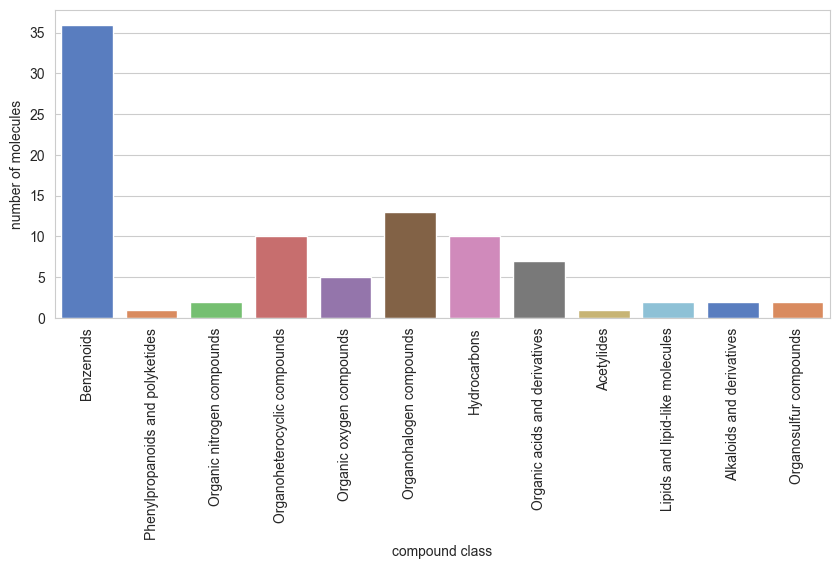

In [8]:
from grape.plots import num_chart
num_chart(class_num_dictionary, fig_size=(10,4))

#### Molecule Weight against Target
Another option for visual analysis is to plot the molecule weight against the target attribute. This might give an indication on how molecule size correlates with the target, often a usual observation.

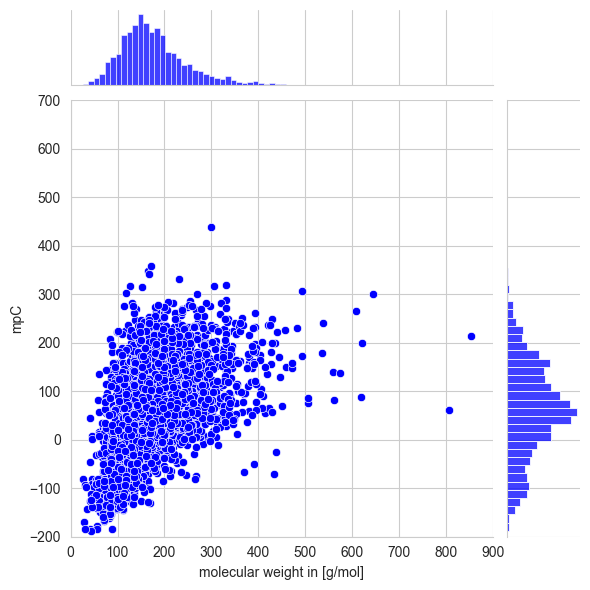

In [9]:
from grape.plots import mol_weight_vs_target
mol_weight_vs_target(data.smiles, data.target, save_fig=True, fig_height=6, target_name='mpC', rescale_data=data, 
                     ylim=(-200,700), xlim=(0,900))

#### Feature number charts
If only a basic analysis of the dataset, is needed, then one can generate number charts based on the featurizion of the molecules. The implementation is built on top of DGL-LIFESCI ```analyze_mols``` function ([github](https://github.com/awslabs/dgl-lifesci/blob/master/python/dgllife/utils/analysis.py)), below is an example.

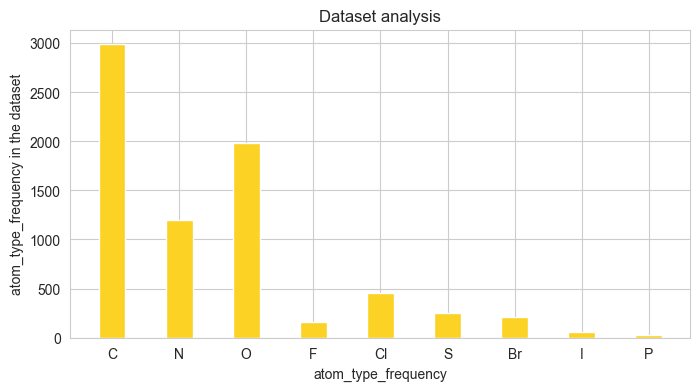

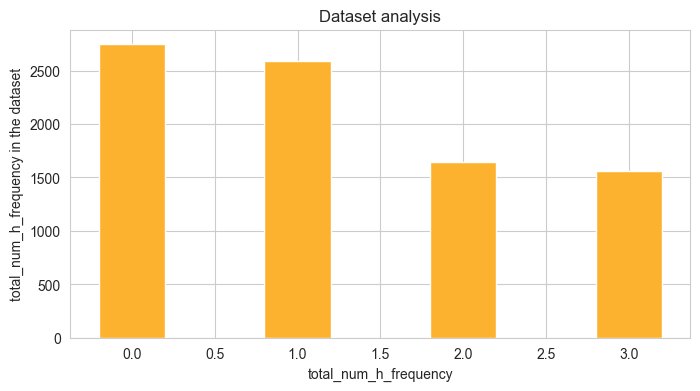

In [10]:
%matplotlib inline

results, figures = data.analysis(download=True, plots=['atom_type_frequency','total_num_h_frequency'], fig_size=[8,4],
                                 save_plots=True)

<Axes: title={'center': 'Heavy atoms distribution'}, xlabel='Number of heavy atoms per molecule', ylabel='Counts'>

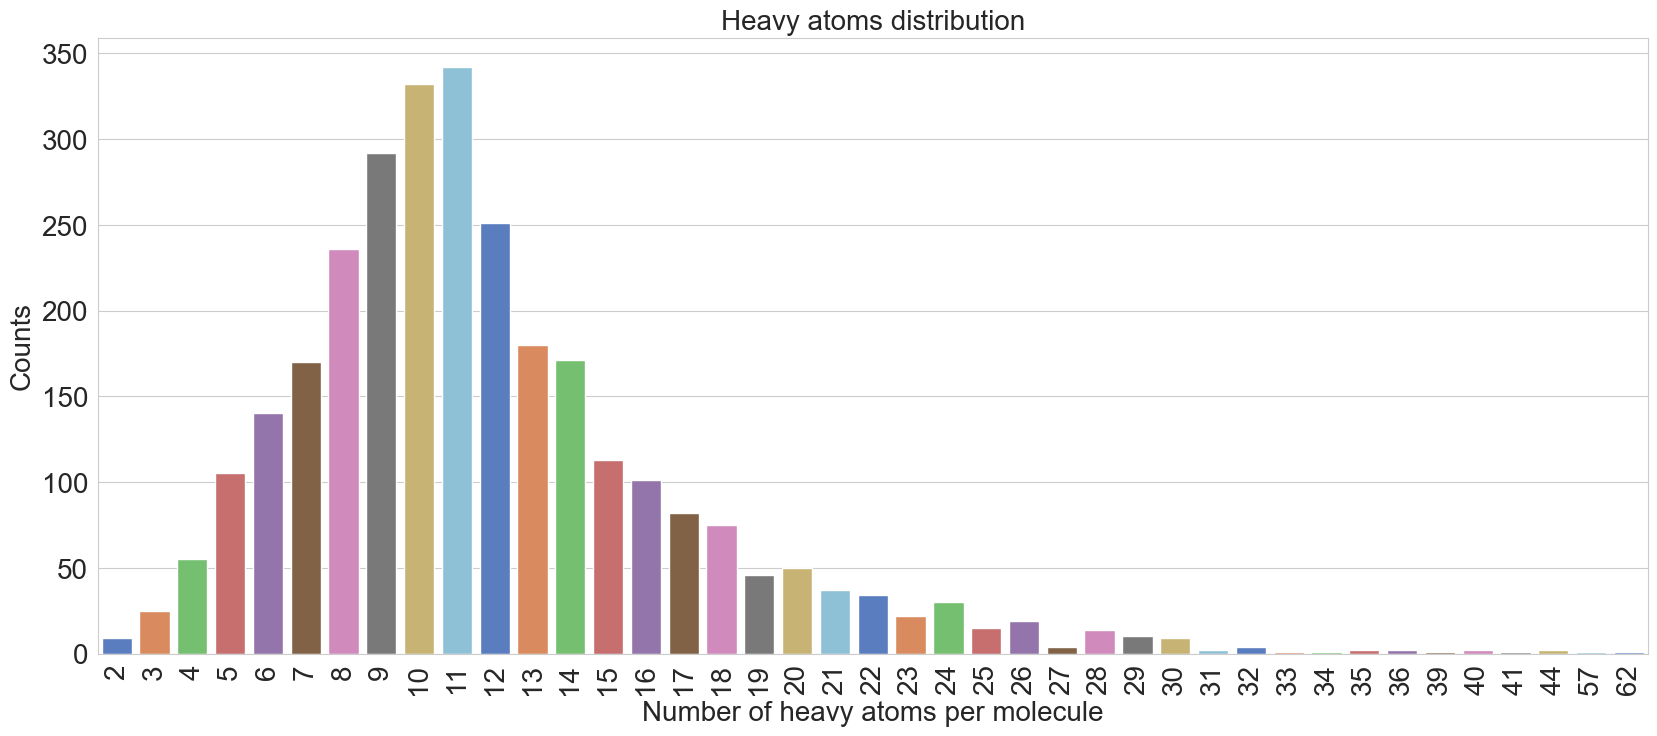

In [11]:
from grape.plots import num_heavy_plot
num_heavy_plot(data.smiles, fig_size=(20,8))

## Clustering and data splitting
There are several ways to split the graph dataset into the training, validation and testing splits, including random, stratified or by molecular weight. A more novel addition is a split based on **Butina clustering** [2], where the molecules are clustered based on the Morgan Fingerprint and the Tanimoto similarity.


In [12]:
from grape.datasets import BradleyDoublePlus
from grape.utils import split_data
data = BradleyDoublePlus()

train, val, test = split_data(data, split_type='random', random_state=42);

## GNN Model
With the data loaded, filtered, featurizerized and split, let's define a Graph Neural Network and test it! We can always find the number of features like thus:

In [13]:
print(f'Node feature dimension: {data.num_node_features}')
print(f'Edge feature dimension: {data.num_edge_features}')

Node feature dimension: 43
Edge feature dimension: 12


#### Model definition
To define a model, all we need is the Message Passing Network (like Weave) and a output model. Below, we call the Weave network and wrap it in the ```SimpleGNN``` module, that just adds a global pooling and output layer to the Message Passing network.

In [14]:
from grape.models import MPNN, MPNN_Model, MGConv, SimpleGNN
import torch

node_hidden_dim = 80
batch_size = 32

model_message = MPNN(num_layers=1, node_hidden_dim=node_hidden_dim, 
                node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features)


model = MPNN_Model(node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features,
                   message_nn=model_message, node_hidden_dim=node_hidden_dim, set2set_steps=3)

                  
print('Model message NN:\n---------------------------------------------------')
print(model_message)
print('')
print('Full model:\n--------------------------------------------------')
print(model)

device = torch.device('cpu')

Model message NN:
---------------------------------------------------
MPNN(
  (relu): ReLU()
  (gru): GRU(80, 80)
  (mlp_in): Sequential(
    (0): Linear(in_features=43, out_features=80, bias=True)
    (1): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=12, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=6400, bias=True)
  )
  (gnn_layers): ModuleList(
    (0): NNConv(80, 80, aggr=mean, nn=Sequential(
      (0): Linear(in_features=12, out_features=80, bias=True)
      (1): ReLU()
      (2): Linear(in_features=80, out_features=6400, bias=True)
    ))
  )
)

Full model:
--------------------------------------------------
MPNN_Model(
  (message): MPNN(
    (relu): ReLU()
    (gru): GRU(80, 80)
    (mlp_in): Sequential(
      (0): Linear(in_features=43, out_features=80, bias=True)
      (1): ReLU()
    )
    (mlp): Sequential(
      (0): Linear(in_features=12, out_features=80, bias=True)
      (1): ReLU()
      (2): Linear(in_features=80

### Loss and Optimizer
Like with any Deep Learning Model, we define a loss function and optimizer.

In [15]:
from torch import nn

loss_func = nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=10**(-2.6), weight_decay=1e-6)

We can additionally define an Early Stopper to help improve the output:

In [16]:
from grape.utils import EarlyStopping
early_stopper = EarlyStopping(patience=50)

As well as a scheduler to reduce the lr whenever the training hits a plateau. Here we use about a third of the patience epochs we used for the EarlyStopper:

In [17]:
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, min_lr=0.0000000000001, patience=30)

### Training
And then we just use the previous found training and validation splits to train the model inside the ```train_model``` function.

In [18]:
from grape.utils import train_model

# train_loss, val_loss = train_model(model = model,
#                                   loss_func = 'mse',
#                                   optimizer = optimizer,
#                                   train_data_loader= train,
#                                   val_data_loader = val,
#                                   batch_size=batch_size,
#                                   epochs=500,
#                                   early_stopper=early_stopper,
#                                    scheduler=scheduler)

model.load_state_dict(torch.load('best_model.pt'))

RuntimeError: Error(s) in loading state_dict for MPNN_Model:
	size mismatch for message.mlp_in.0.weight: copying a param with shape torch.Size([80, 42]) from checkpoint, the shape in current model is torch.Size([80, 43]).

### Loss plot

In [ ]:
# from grape.plots import loss_plot
# loss_plot([train_loss, val_loss], ['train loss', 'test loss'], early_stopper.stop_epoch)

### Testing

In [ ]:
from grape.utils import test_model
test_model(model = model,
           test_data_loader= test,
           loss_func= 'mae');

### Post Processing

With the trained model, we can examine it closer. One way of checking how good a fit is by comparing different losses like MSE, SSE or MAE and seeing where the model might fail. We begin by extracting the test predictions (and latents for later).

In [ ]:
preds = test_model(model=model,
                   test_data_loader=test,
                   loss_func=None,
                   return_latents=True)

Then we calculate some metrics on the predictions:

In [ ]:
from grape.utils import pred_metric
pred_metric(prediction=preds,target=test.y, metrics='all', print_out=True, rescale_data=data);

We could also choose to plot the parity and residual plots:

In [ ]:
from grape.plots import parity_plot, residual_plot
# We rescale the predictions and ground truth before plotting
preds_rescaled, test_y_rescaled = data.rescale_data(preds), data.rescale_data(test.y)
parity_plot(prediction=preds_rescaled,target=test_y_rescaled, mol_weights=test.mol_weights);

In [ ]:
residual_plot(prediction=preds_rescaled,target=test_y_rescaled)

In [ ]:
train_preds = test_model(model=model, loss_func='mae',test_data_loader=train)
val_preds = test_model(model=model, loss_func='mae',test_data_loader=val)
test_preds = test_model(model=model, loss_func='mae',test_data_loader=test)

In [ ]:
overall = 0
overall += pred_metric(prediction=train_preds,target=train.y, metrics='r2', print_out=False)['r2']
overall += pred_metric(prediction=val_preds,target=val.y, metrics='r2', print_out=False)['r2']
overall += pred_metric(prediction=test_preds,target=test.y, metrics='r2', print_out=False)['r2']
print(f'Overall R2: {overall/3}')

In [ ]:
overall = 0
overall += pred_metric(prediction=train_preds,target=train.y, metrics='mae', print_out=False, rescale_data=data)['mae']
overall += pred_metric(prediction=val_preds,target=val.y, metrics='mae', print_out=False, rescale_data=data)['mae']
overall += pred_metric(prediction=test_preds,target=test.y, metrics='mae', print_out=False, rescale_data=data)['mae']
print(f'Overall MAE: {overall/3}')

In [ ]:
from grape.plots import residual_density_plot
residual_density_plot(train_pred=train_preds, val_pred=val_preds, test_pred=test_preds,
                      train_target=train.y, val_target=val.y, test_target=test.y)

Or finally, we could analyze the model latents by applying a PCA model and plotting them based on groups. Let us first classify a subset of our test SMILES and transform the labels into a numeric list for plotting:

In [ ]:
#ids, data_ids = classyfire(test.smiles, log=False)
# -> ids are used for the result analysis and data_ids for specifying the data point from the test set we can use

#class_dict, _ = classyfire_result_analysis(idx=ids, layer=1)

In [ ]:
#indices = list(class_dict.keys())
#labels = list(class_dict.values())
#print(labels)

Now we can generate the PCA plot:

In [ ]:
#import matplotlib.pyplot as plt
#lats = lats.cpu().detach().numpy()
#plt.scatter(lats[:,0],lats[:,1])

In [ ]:
#from grape.plots import pca_2d_plot
#pca_2d_plot(latents=lats[data_ids], labels=labels, save_fig=True, fig_size=(20,12))

In [ ]:
#from grape.plots import tSNE_plot
#tSNE_plot(latents=lats[data_ids], labels=labels)

-----

**References**

[1] Feunang, Y., Eisner, R., Knox, C., Chepelev, L., Hastings, J., Owen, G., Fahy, E., Steinbeck, C., Subramanian, S., Bolton, E., Greiner, R., & Wishart, D. S. (2016). ClassyFire: automated chemical classification with a comprehensive, computable taxonomy. Journal of Cheminformatics, 8(1), 61. https://doi.org/10.1186/s13321-016-0174-y

[2] Butina, D. (1999). Unsupervised Data Base Clustering Based on Daylight's Fingerprint and Tanimoto Similarity: A Fast and Automated Way To Cluster Small and Large Data Sets. Journal of Chemical Information and Computer Sciences, 39(4), 747-750. https://doi.org/10.1021/ci9803381

In [ ]:
set(['train','train','test', 'val'])

In [ ]:
import numpy as np
ls = np.array([1,2,43,4,5,5,6,1,1])
ra = np.arange(len(ls))
print(ra[ls==1])